# Quellen:

Skuli
https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

Data Flow Erklärung
https://towardsdatascience.com/lstms-in-pytorch-528b0440244

Text generation
https://medium.com/deep-learning-with-keras/char-level-text-generation-with-an-lstm-model-e55ba7ff18c2

Sampling
https://medium.com/deep-learning-with-keras/sampling-in-text-generation-b2f4825e1dad

https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277

In [1]:
# Imports:

# from music21 import converter, corpus, instrument, midi, note, chord, pitch, meter
from music21 import *
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

import timeit
from datetime import datetime # model IDs

import os # files 
from torch.utils.data import Dataset 

from IPython.display import Image

from myHelper import myLilyCreate, myLilyRemove, myLilyPNG

ModuleNotFoundError: No module named 'music21'

## Kurze Zusammenfassung

Ziel war es mit Hilfe des Konzept des LSTM-Netzwerk 'Musik' zu erzeugen, d.h. eine analysierbare Folge von Noten und Pausen. Daher auch der Aufbau auf [Skulis Idee(n)](https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5) mit weiteren Konzepten aus dem NLP (größerer Wortschatz, Embedding, erweitertes Sampling). Auf die Wahl einiger Hyperparameter, wie der Trainingssequenzen, Sequenzlänge und der Größe des Embeddings wird in Dateneigenschaften.ipynb eingangen. 

Auch ein kleines Netzwerk mit wenig Training und Finetuning erreicht dieses Ziel, schon so weit, dass lesbare Notensequenzen erzeugt werden.

## Gedanken zur Modellierung
- Datenaufbereitung zur Vorhersage von Elementen (Noten, Akkorde, Pausen) eines Musikstückes
- Idee: Elemente als 'Wörter', bestehend aus der/den Tonart(en), der Oktave, (eventuellen Intervallen) und der Dauer des Elements
- Tonart+Oktave führt zu kleinerem Dictionary als Midizahl, aber Midizal ist einfacher für das Netzwerk?
- Intervalle nicht nötig, da implizit gegeben durch Art+Oktave bzw. Midizahl
- Takstriche, Ja/Nein? -> implizite Information über time signature
- Beispiel ganzes mittleres C ohne Punkt -> Co4wholed0, bestehend aus 'C','o4', 'whole', 'd0' 
- ganzer C-Dur Akkord ohne Punkt -> c4g4e-5wholed0, bestehend aus 'C','o4','G','o4','E-.'o5', 'whole', 'd0'
- '-' und '#' als einzelne Tokens würde das Dictionary weiter verkleinern, aber Länge ist schon relativ klein
- ganze Pause ohne Punkt: 'Rwholed0' bestehend aus 'R', 'whole', 'd0' 
- R willkürlich als 'Wort' für Pause, möglich auch PAUSEwhole oder RESTwhole
- Punkt als Trenner der Elemente eines Wortes, Leerzeichen als Trenner zwischen Wörtern?
- Haltebogen wie in m21 als Wörter 'tie', 'start','continue','stop' modellieren, analog zu Klammern in normaler Sprache
- eventuell ohne 'continue'
- Triolen analog?
- Skuli erstellt keinen String, bestehend aus mehreren Pitchclasses, sondern einen Liste aus Strings einzelner Pitch classes
- Und wandelt diese dann (per dictionary) in Integer um

# Dataset-Klasse zur Modellierung des Datensatzes

In [9]:
'''
Input:
- paths: Pfade innerhalb des m21 Corpus
- sequence_length: gewuenschte Laenge der Subparts
- lang_vocab: ein Vocabular zur Codierung von 'Wort nach Int'
Optional:
- num_subparts: Anzahl der Subparts, die aus einem Stueck extrahiert werden.
  Falls 0, werden alle moeglichen gebildet, sonst num_subparts viele zufaellig
- padding: Art des Padding fuer Subparts am Ende des Stueckes. Moeglich 'zero' oder 'random'
- padding_target_length: Bis zu welcher Laenge gepaddet werden soll. Siehe part2list Funktion
- debug: Zur Ausgabe diverser Variablen 
'''

class FeatureDataset(Dataset):
    def __init__(self, composer, time_ratio, min_elem, max_elem, sequence_length, padding_target_length, lang_vocab, num_subparts=0, padding='zero', debug=False):
        
        # Eingaben ablegen, falls man bei einem bereits initialisierten FeatureDataset-Objekt nochmal darauf zugreifen moechte
        #self.paths = paths
        self.composer = composer
        self.time_ratio = time_ratio # wie oben werden die Stuecke nach einer bestimmten Taktart ausgewaehl
        self.sequence_length = sequence_length
        self.lang_vocab = lang_vocab
        
        
        # In welcher .shape sich die Tensoren befinden
        self.dense_shape = True
        self.conv_shape = False
        self.lstm_shape = False
        
        self.debug = debug
        self.padding = padding
        self.padding_target_length = padding_target_length
        self.space = ' ' 
        
        self.min_elem = min_elem
        self.max_elem = max_elem
        
        # Leere Listen fuer das Extrahieren der Daten
        subparts_notes = [] # wir extrahieren zu erst die subparts als Liste von Note-Objekten
        x_train = [] # hier werden spaeter die einzelnen subparts gesammelt
        y_train = [] # hier werden die n+1-ten Elemente gesammelt
        self.paths = []
        
        part_count = 0
        
        # Corpus nach Komponist und Taktart filtern
        data_corp = corpus.search(self.composer,'composer')
        data_corp = data_corp.search(self.time_ratio)
        
        for work in data_corp:
            temp_score = work.parse() # Werk einlesen und parsen
                        
            sop_part = temp_score.parts[0]
            sop_part = sop_part.recurse() # plaetten
            
            # relevante Elemente zaehlen und evtl den Part ueberspringen
            notes_and_rests = list(sop_part.getElementsByClass([note.Note,note.Rest]))
            nr_sum = len(notes_and_rests)

            if self.min_elem <= nr_sum <= self.max_elem: # Falls die Anzahl der Elemente den Vorgaben entspricht

                part_str = self.part2List(notes_and_rests, self.padding_target_length) # Laenge des Paddings vorne/hinten, ganzzahlig und aufgerundet
                part_int = self.string2numerical(part_str, self.lang_vocab) # Int-Codierung 

                subparts = self.get_all_n_subparts(part_int, self.sequence_length + 1) # Alle moeglichen num_notes langen Subparts
                
                for subpart in subparts:                
                    #x_train.append(self.standardize(subpart[0:-1])) # n langer Subpart als Trainingsfall
                    x_train.append(subpart[0:-1])
                    y_train.append(subpart[-1]) # 'n+1' Element des Subpart als Zielvariable 
                    
                    self.paths.append(temp_score.corpusFilepath) # Pfad merken
                    
                part_count +=1 

                                
        # Erstellen von Tensoren.
        # Das Torch-Netzwerk moechte i.d.R. mit float32 Werten arbeiten
        # torch.nn.CrossEntropyLoss() braucht die Y-Werte mit dtype = long
        # embedding will long Tensor
        
        self.X_train = torch.tensor(x_train, dtype=torch.long) #float32
        self.Y_train = torch.tensor(y_train, dtype=torch.long)
        
        print('Number of parts: ',part_count)
        print("Training Shape before reshape:", self.X_train.shape, self.Y_train.shape)
        return
    
    '''
    Input:
    - part: Ein Part als Score-Objekt, auf welches vorher recurse oder flatten angewandt wurde
    - words: Liste von Woertern aus der zufaellig das Padding gebaut werden soll
    - padding_length: Anzahl der Woerter, die (vorne und) hinten hinzugefuegt werden sollen
    - padding: Art des Padding. Entweder mit einem 'Leerzeichen'/Nullelement oder zufaelligen 'Woertern' aus words
    Output:
    Sei 
    pl= padding_length 
    part = {part_element_1,...,part_element_m}
    c(part_element_i) = 'Codierung des i-ten Elements'
    -> Liste = [pad_vorne_1,...,pad_vorne_pl,c(part_element_1),...,c(part_element_m),pad_hinten_1,...,pad_hinten_pl]
    Der Part wird also in eine Liste von Codierungen der einzelnen Elemente umgewandelt und dem Padding entsprechend verlaengert
    '''
    def part2List(self,part, target_len = 0):
        debug = False
        if debug:
            print('-----Start part2List-----')
            print('Padding ', padding)
            print('space ', space)
        part_list = []
        null_elem = 'null'
        
        for part_element in part: # durch den Part iterieren
            
            if isinstance(part_element, note.Note): # falls Note gefunden
                part_list.append(part_element.name) # Name (Pitch-Klasse) der Note
                part_list.append('o'+str(part_element.octave)) # Okatevenzahl, liegt als int vor, muss umgewandelt werden
                part_list.append(part_element.duration.type) # Duration, 'quarter', 'half' etc.
                part_list.append('d'+str(part_element.duration.dots)) # Anzahl der Punkte
                part_list.append(' ') # entsprechend der Codierung
                
            elif isinstance(part_element, chord.Chord): # falls Akkord gefunden
                if debug:
                    print('Chord')
            
            elif isinstance(part_element, note.Rest): # falls Pause gefunden
                # part_list.append('R')
                part_list.append(part_element.duration.type) # Duration, 'quarter', 'half' etc.
                part_list.append('d'+str(part_element.duration.dots)) # Anzahl der Punkte
                part_list.append(' ') # entsprechend der Codierung
                
        # Padding vorne
        while len(part_list) < target_len:
            part_list.insert(0,null_elem)
        '''    
        # Padding hinten        
        for _ in range(padding_length): # bist padding_length wird am Ende der Liste ein Element hinzugefuegt
            if padding == 'zero': # das Nullelemt wird hinzugefuegt. Hat im Vokabular den Wert 0
                part_list.append(null_elem)
            elif padding =='random':
                part_list.append(random.choice(padding_words)) # zufaellige Auswahl aus den uebergebenen Woertern
        '''
        if debug:
            print('-----End part2List-----')
        return part_list
    
    def string2numerical(self, string_list, lang_vocab):
        debug = False
        if debug:
            print('-----Start string2numerical-----')
        
        numerical_list = []

        for element in string_list:
            try:
                numerical_list.append(lang_vocab[element])
            except KeyError:
                numerical_list.append(lang_vocab['null'])
            
        if debug:
            print('-----End string2numerical-----') 
            
        return numerical_list
    
    def standardize(self, int_list):
        mean = np.mean(int_list) # Mittelwert der Midizahlen
        std = np.std(int_list) # Standardabweichung der Midizahlen
        
        if std == 0: # Alle Werte in der Liste sind gleich, eventuell Liste entfernen, tritt aber nicht SO oft auf
            std = 1
        
        stan_list = []
        for elem in int_list:
            stan_list.append((elem-mean)/std)
            
        return stan_list
        
    '''
    - Erzeugt alle moeglichen Subparts (oder Sublisten) der Laenge n des Eingabeparts.
    - Der Eingabepart liegt in der oben beschriebenen Integer-Codierung vor.
    - 'alle moeglichen heisst', falls z.B. die gewuenschte Laenge der Subparts 25 ist und die Laenge des Eingabeparts 100, 
      kann man als Startindex fuer den Subpart 0 bis 75 waehlen.
    '''
    def get_all_n_subparts(self, part_int, len_subpart):
        all_subparts = [] # Liste in der alle Subparts abgelegt werden
        
        # Zaehle Anzahl der zulaessigen Elemente (Note, Res, evtl Chord)
        elements_in_part = len(part_int)
            
        max_start_index = self.max_index(elements_in_part, len_subpart) # maximaler Startindex
        
        if max_start_index < 0: # tritt ein falls der Part zu kurz ist (dann gibt max_index() eine -1 zurueck)
            return all_subparts
        
        start_index = 0 # erster Startindex
        while max_start_index > start_index: # so lange der maximale Startindex nicht erreicht ist wiederhole
            subpart = [] # Liste in der die Notenobjekte abgelegt werden
            
            for i in range(len_subpart): 
                subpart.append(part_int[start_index+i])
                
                # subpart.append(flat_part_notes[i+start_index])
            start_index += 1
            all_subparts.append(subpart.copy())
            
        return all_subparts
      
    # Hilfsfunktion fuer maximal moeglichen Index
    def max_index (self, len_total, len_sub):
        ind = len_total-len_sub-1
        if ind < 0:
            return -1
        else:
            return len_total-len_sub-1
        
    # Diverse Reshapes fuer verschiedene Modellarten
    def reshape_for_conv(self):
        if not self.conv_shape:
            self.X_train = torch.reshape(self.X_train, (self.X_train.shape[0], self.num_features, self.X_train.shape[1]))
            self.conv_shape = True
            self.dense_shape = False
            self.lstm_shape = False
            print('reshape')
            print(self.X_train.shape)
        else:
            print('no reshape')
            print(self.X_train.shape)
        return
    
    def reshape_for_dense(self):
        if not self.dense_shape:
            self.X_train = nn.Flatten(self.X_train)
            self.dense_shape = True
            self.conv_shape = False
            self.lstm_shape = False
            print('reshape')
            print(self.X_train.shape)
        else:
            print('no reshape')
            print(self.X_train.shape)
        return
    
    def reshape_for_lstm(self):
        if not self.lstm_shape:
            self.X_train = torch.reshape(self.X_train, (self.X_train.shape[0], self.num_features, self.sequence_length)) # batch_size, seq_length, num_features ???????
            self.dense_shape = False
            self.conv_shape = False
            self.lstm_shape = True
            print('reshape')
            print('X_train.shape: ',self.X_train.shape)
            print('Y_train.shape: ',self.X_train.shape)
        else:
            print('no reshape')
            print('X_train.shape: ',self.X_train.shape)
            print('Y_train.shape: ',self.X_train.shape)
        return
    
    # Hilfsfunktion um die TimeSignature eines Parts herauszufinden. 
    def partTSratioString(self, part):
        for elem in part:
            if isinstance(elem, meter.TimeSignature):
                return elem.ratioString
        return 'null'
    
    # fuer den Dataloader noetig
    def __len__(self):
        return len(self.Y_train)
    
    # get-Methode muss entsprechend der Tensoren angepasst werden, ist hier recht simpel
    def __getitem__(self, idx):
        return self.X_train[idx], self.Y_train[idx], self.paths[idx]

# Funktion zur Erstellung des Wortschatzes zur Modellierung

In [10]:
'''
Input:  paths - music21 Verzeichnis
        ratio - Taktverhaeltnis als String, als so wie es in music21 meter.TimeSignature.ratioString vorliegt z.B. '4/4', '3/4' etc.
Output: einen wie oben aufgeteilten Wortschatz, gebildet aus dem mit paths definierten und durch ratio gefilterten Corpus. (Es werden nur parts mit Taktart ratio betrachtet)       
'''
def getVocab(composer, time_ratio, min_elem, max_elem):
    # Nutzen set(), weil im Folgenden schneller als Listen (nicht getestet)
    # set() verhaelt sich wie eine Menge (Set) aus der Mathematik 
    # d.h. im Folgenden: set.add() analog zu list.append() mit Vermeidung von Duplikaten
    pitch_classes = set() 
    octaves = set()
    durations = set()
    dots = set()
    
    #min_elem = 30
    #max_elem = 70
    
    part_count = 0 # zaehlen der betrachtetn Parts. Wird mit der Ausgabe des DataSet-Objekts spaeter als kleiner 'Sanity Check' genutzt
    
    # Corpus nach Komponist und Taktart filtern
    data_corp = corpus.search(composer,'composer')
    data_corp = data_corp.search(time_ratio)
    
    for work in data_corp:
        temp_score = work.parse() # Werk einlesen und parsen
        
        sop_part = temp_score.parts[0]
        sop_part = sop_part.recurse() # plaetten

        # relevante Elemente zaehlen und evtl den Part ueberspringen
        notes = list(sop_part.getElementsByClass(note.Note)) # getElementsByClass gibt Iterator zurueck, muss als Liste 'fixiert' werden
        rests = list(sop_part.getElementsByClass(note.Rest))
        
        num_notes = len(notes)
        num_rests = len(rests)
        nr_sum = num_notes + num_rests
       
        if min_elem <= nr_sum <= max_elem: # Falls die Anzahl der Elemente den Vorgaben entspricht
            for p_note in notes: # Note durchgehen
                # im Folgenden, set.add() analog zu list.append() mit Vermeidung von Duplikaten
                pitch_classes.add(p_note.name) # Name (Pitch-Klasse) der Note
                octaves.add('o'+str(p_note.octave)) # Okatevenzahl, liegt als int vor, muss umgewandelt werden
                durations.add(p_note.duration.type) # Duration, 'quarter', 'half' etc.
                dots.add('d'+str(p_note.duration.dots)) # Anzahl der Punkte

            for p_rest in rests: # Pausen durchgehen
                durations.add(p_rest.duration.type) # Duration, 'quarter', 'half' etc.
                dots.add('d'+str(p_rest.duration.dots)) # Anzahl der Punkte

                
            part_count +=1 # zaehlen 
    
    print('Number of parts: ',part_count)
                    
    return list(pitch_classes), list(octaves), list(durations), list(dots)  

# Wortschatz und Featureset erzeugen

In [11]:
# Hyperparam fuer den Corpus
composer = 'bach'
time_ratio = '4/4'
min_elem = 30
max_elem = 65

In [12]:
# Wortschatz
pitch_classes_bach, octaves_bach, durations_bach, dots_bach = getVocab(composer, time_ratio, min_elem, max_elem)

Number of parts:  258


In [13]:
# check, einzelne Listen
other = ['null',' ']

print(pitch_classes_bach)
print(octaves_bach)
print(durations_bach)
print(dots_bach)
print(other)

['B-', 'C', 'C#', 'F', 'F#', 'B', 'A-', 'D-', 'A#', 'D', 'G-', 'A', 'E', 'G', 'D#', 'E-', 'G#']
['o3', 'o4', 'o5', 'o6']
['eighth', 'whole', '32nd', 'quarter', 'half', '16th']
['d1', 'd0']
['null', ' ']


In [14]:
# weitere Vorarbeit fuer Featureset
words = other + pitch_classes_bach + durations_bach + dots_bach + octaves_bach
word_to_int = dict((word, number) for number, word in enumerate(words))
int_to_word = {}
for key in word_to_int.keys():
    int_to_word[word_to_int[key]] = key
print(int_to_word)

{0: 'null', 1: ' ', 2: 'B-', 3: 'C', 4: 'C#', 5: 'F', 6: 'F#', 7: 'B', 8: 'A-', 9: 'D-', 10: 'A#', 11: 'D', 12: 'G-', 13: 'A', 14: 'E', 15: 'G', 16: 'D#', 17: 'E-', 18: 'G#', 19: 'eighth', 20: 'whole', 21: '32nd', 22: 'quarter', 23: 'half', 24: '16th', 25: 'd1', 26: 'd0', 27: 'o3', 28: 'o4', 29: 'o5', 30: 'o6'}


In [15]:
# Hyperparam fuer Featureset
len_sequence = 250
padding_target_length = 350
lang_vocab = word_to_int
n_classes = len(lang_vocab)
print(len(lang_vocab))

31


In [16]:
# Featureset erzeugen
start = timeit.default_timer()
# paths, sequence_length, padding_target_length, lang_vocab, time_ratio, num_subparts=0, padding = 'zero', padding_ratio = 0, debug = False
feature_set = FeatureDataset(composer,time_ratio, min_elem, max_elem, len_sequence, padding_target_length, lang_vocab, 0, 'zero', False)
stop = timeit.default_timer()
print('Runtime: ', stop - start) 

Number of parts:  258
Training Shape before reshape: torch.Size([25284, 250]) torch.Size([25284])
Runtime:  31.591651499999898


In [17]:
# Testset mit anderen Hyperparam erzeugen
composer = 'bach'
time_ratio = '4/4'
min_elem_test = 71
max_elem_test = 120

start = timeit.default_timer()
test_set = FeatureDataset(composer,time_ratio, min_elem_test, max_elem_test, len_sequence, padding_target_length, lang_vocab, 0, 'zero', False)
stop = timeit.default_timer()
print('Runtime: ', stop - start) 

Number of parts:  24
Training Shape before reshape: torch.Size([4440, 250]) torch.Size([4440])
Runtime:  29.227506200000107


# Modell

grundlegende Strutkur basiert auf Skuli

Embed zu LSTM1 bsaiert auf :  
https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

https://discuss.pytorch.org/t/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers/15398

pad_idx, siehe hier:
https://stackoverflow.com/questions/61172400/what-does-padding-idx-do-in-nn-embeddings  
Schliesse daraus, dass das Padding Element index 0 im vocab haben muss.  

https://stackoverflow.com/questions/45394949/what-is-dimensionality-in-word-embeddings

Diagram zu LSTM:  
https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm  
Daraus folt die aktuelle Erkenntnis, dass hs NICHT uebergeben wird und jede Sequenz bei h0 startet. Da der hidden state nicht ueber Beispiele hinweg 'gelernt' wird.  
Oder auch nicht  
https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html
-> Letztendlich ist dies ein weiterer Hyperparamter und fuehrt uns zu den LSTM Typen stateful/stateless.

Mehr Embedding 
https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch

## Embedding

Der Layer hat i.A. die Gestalt sequence_length x vocab_size x embedding_dim. Also in unserem Fall 200x32x3 (Siehe Dateneigenschaften.ipynb  
Wie sieht das ganze dann im Netzwerk aus? 
Im Prinzip ist ein Embedding nichts anderes als eine spezielle Form eines linearen Layers. Wie wird also der Output eines linearen Layers an ein LSTM uebergeben?:

Aus der Dokumentation zu nn.Embedding(): <br>
**input:** (\*) IntTensor or LongTensor of arbitrary shape containing the indices to extract <br>
**output:** (\*, H), mit (\*) = input_shape und H = embedding_dim

Aus der Dokumentation zu nn.LSTM():  
**input:** tensor of shape (N,L,H_in) when batch_first=True, mit N = batch_size, L = sequence_length und H_in = input_size  
Also (bs, 200, vocab_size x embedding_dim)

In [18]:
class MY_LSTM(nn.Module):
    def __init__(self, len_sequence, lang_vocab):
        super(MY_LSTM, self).__init__()
        
        self.len_sequence = len_sequence
        self.lang_vocab = lang_vocab
        self.n_classes = len(lang_vocab)
        self.embedding_dim = 3
        self.context_size = 25
        
        self.n_layers1 = 1
        self.hidden_size1 = 6
        self.dr1 = 0.2 # dr = dropout rate
        
        self.n_layers2 = 1
        self.hidden_size2 = 12
        self.dr2 = 0.3
        
        self.n_layers3 = 1
        self.hidden_size3 = 6
        
        self.dr3 = 0.3


        # self.hidden_dim = hidden_dim
        # self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        self.embeds = nn.Embedding(self.n_classes, self.embedding_dim, padding_idx=self.lang_vocab['null'])
        
        self.lstm1 = nn.LSTM(self.embedding_dim*self.context_size, self.hidden_size1, self.n_layers1, batch_first = True)
        self.drop1 = nn.Dropout(p=self.dr1)
        
        self.lstm2 = nn.LSTM(self.hidden_size1, self.hidden_size2, self.n_layers2, batch_first = True)
        self.drop2 = nn.Dropout(p=self.dr2)
        
        self.lstm3 = nn.LSTM(self.hidden_size2, self.hidden_size3, self.n_layers3, batch_first = True)
        
        self.dense1 = nn.Linear(self.hidden_size3*(self.len_sequence-self.context_size+1), 512)
        self.drop3 = nn.Dropout(p=self.dr3)
        
        
        self.out = nn.Linear(512, self.n_classes) 
        
    def forward(self, x, hs1=None, hs2=None, hs3=None):
        
        x = self.embeds(x)
        
        # uebergabe von embed zu lstm nicht ohne weiteres moeglich, falls context_size > 1 gewuenscht
        x = x.unfold(1, self.context_size, 1)  
        x = x.reshape(x.size(0), x.size(1), -1) 
        
        x, hs1 = self.lstm1(x,hs1)
        x = self.drop1(x)
        
        x, hs2 = self.lstm2(x,hs2)
        x = self.drop2(x)
        
        x, hs3 = self.lstm3(x,hs3)
        x = torch.flatten(x, start_dim =1)
        

        x = self.dense1(x)
        x = self.drop3(x)
 
        x = self.out(x)
        
        return x,hs1,hs2,hs3

# Training

In [19]:
'''
Input:
    - Zielwerte aus dem Datensatz
    - Vorhersagen des Modells
Output:
    - falls Vorhersage dem Zielwert entspricht True, sonst False
'''
def hit(target, pred): 
    # das LSTM gibt keine als Wahrscheinlichkeitsverteilung interpretierbaren Werte (logits) aus, deshalb muss Softmax angewandt werden.
    # Dies ist eine Art Pytorch Eigenheit, man koennte auch im Modell auf den letzten Layer Softmax anwenden, dann funktioniert 
    # torch.nn.CrossEntropyLoss() aber nicht mehr.
    
    pred_softmax = torch.log_softmax(pred.view(-1),0)
    
    # der folgenden Befehl koennte sicher auch einfach gestaltet werden
    # detach() - entfernt Gradienten, welche einem Tensor zugewiesen werden
    # reshape(-1) - plaettet (flatten) einen Tensor, d.h. wirft alle Werte in einer Dimension zusammen
    # numpy() - wandelt den Tensor in ein Numpy Array um
    # argmax() - gibt den Index mit dem maximalen Wert zurueck
    # -> argmax gibt fuer die 1-Hot-Kodierung die Klasse zurueck,
    # -> argmax gibt fuer einen Vektor mit Klassen-Wahrscheinlichkeiten, die Klasse mit der maximalen Wahrscheinlichkeit zurueck
    
    if target.detach().reshape(-1).numpy() == pred_softmax.detach().reshape(-1).numpy().argmax():
        return True
    else:
        return False

'''
Dient neben einfachen Accuracy-Messung auch dem Debuggen des Netzwerkes
Input:
    - Modell
    - Daten-Loader
    - Ist Modell ein LSTM? -> True/False
    - Zusaetzliche Textausgabe gewuenscht? -> True/False
Output:
    - Verhaeltnis von richtigen Vorhersagen zu falschen Vorhersagen auf der Menge im Loader
'''  
def get_acc(model, loader, lstm = False, verbose=False): # performance auf val-set
    model.eval()
    num_classes = model.n_classes
    hits = 0
    tries = 0
    debug = 1
    for x_val, y_val, path in loader:
        
        if debug < 1:
            print('----------*----------')
            print('x_val.shape', x_val.shape)
            print('x_val', x_val)

        
        yhat, _,_,_ = model(x_val)
        
        if debug < 1:
            print('----------*----------')
            print('yhat.shape', yhat.shape)
            print('yhat', yhat)
            print('----------')
            print('y_val.shape', y_val.shape)
            print('y_val', y_val)
            debug += 1
    
        for target, pred in zip(y_val, yhat):
            tries += 1
            if hit(target, pred):
                hits +=1
                
    accuracy = hits/tries
    if verbose:        
        print('Tries', tries)
        print('Number of hits:', hits)
        print('Accuracy', accuracy)
        # bei einem zufaellig gewichteten/untrainierten Modell wuerde man eine Treffsicherheit von 1:(Anzahl Klassen) erwarten
        print('Random Ratio')
        print(1/num_classes)
    
    return accuracy

## Hyperparam und weitere Vorarbeit (diverse Loader erzeugen etc.)

In [20]:
learning_rate = 0.001
batch_s = 64

In [21]:
train_size = int(0.8 * len(feature_set)) # split 0.2
val_size = len(feature_set) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(feature_set, [train_size, val_size])

# train_loader erstellen
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_s, drop_last=True,shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_s)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_s)

In [22]:
# Modell erzeugen
my_lstm1 = MY_LSTM(len_sequence, lang_vocab)
model_epoch = 0
# Hyperparam festlegen
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(my_lstm1.parameters(), lr=learning_rate) 

In [23]:
# Test auf Validierungsset
start = timeit.default_timer()
print('Validation Accuracy')
get_acc(my_lstm1, validation_loader,True,True)
stop = timeit.default_timer()
print('Runtime: ', stop - start)  

Validation Accuracy
Tries 5057
Number of hits: 1
Accuracy 0.00019774569903104609
Random Ratio
0.03225806451612903
Runtime:  16.76145550000001


In [24]:
# Test auf Testset
start = timeit.default_timer()
print('Test Accuracy')
get_acc(my_lstm1, test_loader,True,True)
stop = timeit.default_timer()
print('Runtime: ', stop - start)

Test Accuracy
Tries 4440
Number of hits: 3
Accuracy 0.0006756756756756757
Random Ratio
0.03225806451612903
Runtime:  12.637352100000044


## Trainingsloop

Zu beachten sind vor allem batchsize=64 und stateless LSTM, d.h. wir resetten den Hiddenstate nach jeder Episode.
Der Rest im im Prinzip Standard. 

In [22]:
start = timeit.default_timer()

num_epochs = 20

avg_losses = []
epoch_accuracies_val = []
epoch_accuracies_train = []

max_acc = 0
my_lstm1.train()

debug = False

for epoch in range(num_epochs):
    ep_start = timeit.default_timer()
    print('Starting model_epoch: ', model_epoch+1)
    my_lstm1.train()
    epoch_losses = []
    
    # Nach jeder Episode die hs resetten -> stateless LSTM
    hs1 = None 
    hs2 = None
    hs3 = None
    
    # hits nur pro Epoche zaehlen
    epoch_hits = 0
    epoch_tries = 0
    
    for x_batch, y_batch, _ in train_loader:
        optimizer.zero_grad() # 'caluclate the gradient, manually setting to 0'
        output, hs1, hs2, hs3 = my_lstm1.forward(x_batch, hs1, hs2, hs3) #forward pass
        
        hs1 = tuple([h.data for h in hs1])
        hs2 = tuple([h.data for h in hs2])
        hs3 = tuple([h.data for h in hs3])
        
        if debug:
            print(output.shape)
            print(y_batch.shape)
        
        # Genauigkeit im Training:
        for target,pred in zip(y_batch,output):
            if hit(target,pred):
                epoch_hits +=1
            epoch_tries +=1

        loss = criterion(output, y_batch)
        epoch_losses.append(loss.item())
        loss.backward() #calculates the loss of the loss function
         
        optimizer.step() #improve from loss, i.e backprop
        #losses.append(loss)
    
    
    # weitere Daten zur Accuracy erheben und ablegen
    acc_train = epoch_hits/epoch_tries

    epoch_avg = sum(epoch_losses)/len(epoch_losses)
    avg_losses.append(epoch_avg)
    
    acc_test = get_acc(my_lstm1, test_loader,True, _)
    acc_val = get_acc(my_lstm1, validation_loader,True, _)
    
    epoch_accuracies_val.append(acc_val)
    epoch_accuracies_train.append(acc_train)
    
    # Modell verbessert sich -> Modell speichern
    if acc_train>max_acc:
        max_acc = acc_train
        name = 'lstm_ebd_3_con10_512_'+str(epoch+1)+'_'+str(max_acc)
        # name = 'lstm_embed_3_6126_512_'+str(epoch+1)+'_'+str(acc)+'_'+str(datetime.now())
        torch.save(my_lstm1.state_dict(), 'models/'+name)
    
    # letzte Epoche -> Modell speichern
    elif (epoch+1)== num_epochs:
        name = 'lstm_ebd3_con10_512_'+str(epoch+1)+'_'+str(acc_train)
        torch.save(my_lstm1.state_dict(), 'models/'+name)
    
    model_epoch += 1
    print("Epoch: %d, avg loss: %1.5f" % (model_epoch, epoch_avg)) 
    print('acc_train: ', acc_train)
    print('acc_val: ',acc_val)
    print('acc_test:', acc_test)
 
    ep_stop = timeit.default_timer()
    print('Ep_Runtime: ', ep_stop - ep_start)
    print('---------*---------*----------*---------*---------*----------*---------*---------*----------')
    
stop = timeit.default_timer()
print('Runtime: ', stop - start)  

Starting model_epoch:  1
Tries 4440
Number of hits: 2851
Accuracy 0.6421171171171172
Random Ratio
0.03225806451612903
Tries 5057
Number of hits: 3443
Accuracy 0.6808384417638916
Random Ratio
0.03225806451612903
Epoch: 1, avg loss: 1.32390
acc_train:  0.5693235759493671
acc_val:  0.6808384417638916
acc_test: 0.6421171171171172
Ep_Runtime:  164.55161500000003
---------*---------*----------*---------*---------*----------*---------*---------*----------
Starting model_epoch:  2
Tries 4440
Number of hits: 2981
Accuracy 0.6713963963963964
Random Ratio
0.03225806451612903
Tries 5057
Number of hits: 3618
Accuracy 0.7154439390943247
Random Ratio
0.03225806451612903
Epoch: 2, avg loss: 0.84465
acc_train:  0.6918018196202531
acc_val:  0.7154439390943247
acc_test: 0.6713963963963964
Ep_Runtime:  147.52275110000005
---------*---------*----------*---------*---------*----------*---------*---------*----------
Starting model_epoch:  3
Tries 4440
Number of hits: 3054
Accuracy 0.6878378378378378
Random Ra

# Generierung

- generate() soll alle gängigen Sampling-Mehtoden ausführen können (greedy, top k, top p und temperature) 

In [25]:
# top_k nach: https://medium.com/deep-learning-with-keras/sampling-in-text-generation-b2f4825e1dad
# k=1: Greedy, da a > b -> softmax(a)>softmax(b)

# temperature nach: https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277
'''
Lower temperatures make the model increasingly confident in its top choices, while temperatures greater than 1 decrease confidence. 
0 temperature is equivalent to argmax/max likelihood, while infinite temperature corresponds to a uniform sampling.
'''
# top_p nach: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
# Wird nach top_k angewandt, bevor zum zweiten mal softmax angewandt wird. 

'''
Also:
prediction = softmax(samp_top_p(samp_top_k(softmax(model(input))))/temperature)
oder:
pred_1 = model(input)                 -> output aus Netzwerk
pred_2 = softmax(pred_1)              -> 'erste' Wahrscheinlichkeitsverteilung, auf Grund von Pytorch getrennt vom Netzwerk
pred_3 = top_k(pred_2)                -> die groessten k W'keiten, ergeben aufsummiert nicht mehr 1 -> keine 'vollstaendige' Verteilung mehr
prediction = softmax(pred_3)          -> softmax auf die uebrigen W'keiten gibt uns wieder eine 'vollstaendige' Verteilung


Optional, wird zwar im Folgenden immer angewandt, fuehrt aber mit den Werten top_p=1 und temperature=1 zu keiner Veraenderung
pred_4 = top_p(pred_3)                -> die groessten k W'keiten nochmal nach top_p gefiltert
pred_5 = pred_4/temperature           -> Temperature Skalierung anwenden
prediction = softmax(pred_5)          -> softmax auf die uebrigen W'keiten gibt uns wieder eine 'vollstaendige' Verteilung
'''


def generate(desired_length, model, lang_vocab, lstm = False, initial_sequence=[], top_k=1, temperature=1, top_p=1):
    model.eval()      
    desired_sequence = []
    
    verbose = False # mehr Ausgabe fuer limitierte Anzahl an Iterationen
    verbose_count = 0
    verbose_max = 5
    
    if temperature==0:
        print('Temperatue of 0 set to 1.')
        temperature = 1
    
    # Eingabesequenz ist entweder leer (default) oder zu kurz fuer das Modell
    # -> zufaellige Sequenz erstellen
    if len(initial_sequence) < model.len_sequence: 
        initial_sequence = [] 
        for _ in range(model.len_sequence): 
            initial_sequence.append(random.choice(list(lang_vocab.values())))
            # an initial_sequence wird ein zufaelliger Integer aus dem Dict angehaengt
    
    
    for _ in range(desired_length):
        
        # Bearbeiten der Startsequenz

        #stan_sequence = standardize(initial_sequence) # Standardisieren der Startsequenz
        init_tens = torch.tensor(initial_sequence, dtype=torch.long) # In Tensor 'umwandeln'
        init_tens = torch.reshape(init_tens, (1, model.len_sequence)) # Reihenfolge, batch_first=True 
            
        # Prediction zur Startsequenz erhalten
  
        pred,_,_,_ = model(init_tens) 
        
        pred_softmax = (torch.log_softmax(pred.view(-1),0)) # Pytorch -> Modell hat keine Softmax auf dem letzten Layer 
        
        if verbose and verbose_count < verbose_max:
            print('----------*----------*----------*----------*----------*----------*----------*----------')
            print('pred', pred) 
            print('pred_smax', pred_softmax)
            print('cumsum', torch.cumsum(pred_softmax,0))
            
        top_prob, top_ind = torch.topk(pred_softmax,top_k) # die k hoechsten W'Keiten und Indizes im Ursprungstensor. (Indizes entsprechen Codierung). SORTIERT!
        # Mit dem Auswaehlen der groessten k, addieren sich diese W'keiten i.A. nicht mehr zu 1 auf -> keine W'keitsverteilung mehr -> nochmal Softmax anwenden

        top_prob, top_ind = topp(top_prob, top_ind, top_p) # topp anwenden
 
        top_prob_redistributed = (torch.softmax(top_prob.view(-1)/temperature,0) ) # Hier wird temperature andgewandt.
        
        top_prob_redistributed = top_prob_redistributed.detach().numpy()   # spaeter fuer numpy
        top_ind = top_ind.view(-1).detach().numpy()
        
        new_elem = np.random.choice(top_ind,1, p=top_prob_redistributed)[0] # Neues Element entsprechend der erzeugtem Verteilung
        
        if verbose and verbose_count < verbose_max:
            print('Top Probabilities: ',top_prob_redistributed)
            print('Top Elements: ',top_ind)
            print('Chosen Element: ',new_elem)
            verbose_count +=1
            
        desired_sequence.append(new_elem) # neues Element ablegen
        initial_sequence.append(new_elem) # neues Element ablegen
        initial_sequence = initial_sequence[1:] # erstes Element entfernen

        
    return desired_sequence

'''
    Hilfsfunktion zum Top-p-Sampling. Weist noch Fehler auf
    Input:
        - sorted_probabilites <- sortierte W'keiten einer Verteilung
        - elements <- Indizes der zu vorhersagenden Elemente
        - p <- genwuenschtes p
    Output:
        - topp_prob <- W'keiten nach top-p
        - topp_elem <- zugehoerige Indizes, s.o.
'''
def topp(sorted_probabilities,elements,p):
    max_ind = 0
    cumsum = torch.cumsum(sorted_probabilities,0)
    
    if p ==1:
        return sorted_probabilities, elements
    
    for elem in cumsum.detach().numpy():
        if elem >= p:
            break
        max_ind+=1
        
    topp_prob = sorted_probabilities.narrow(0,0,max_ind+1)
    topp_elem = elements.narrow(0,0,max_ind+1)
    return topp_prob, topp_elem

'''
    Zum Standardisieren einer Sequenz. Hier nicht so ohne Weiteres moeglich, alte Idee
    Input:
        - Sequenz
    Output
        - standardisierte Sequenz
'''
def standardize(sequence):
    mean = np.mean(sequence) # Mittelwert 
    std = np.std(sequence) # Standardabweichung 
    if std == 0: # Sonderfall, falls (fast) alle Elemente gleich sind
        std = 1
        
    stan_sequence = [] # standardisierte Sequenz
    for elem in sequence:
        stan_sequence.append((elem-mean)/std)
    
    return stan_sequence

'''
    Wandelt Sequenz aus Integern, welche Elemnten aus dem Wortschatz entsprechen in eine Sequenz aus Strings um.
    Input:
        - sequence <- Integer-Sequenz, muss offensichtlich dem mituergebenen Wortschatz entsprechen
        - int2wird_dict <- Wortschatz als dictionary
    Output:
'''
def int_sequence_to_music(sequence, int2wrd_dict):
    music = []
    for elem in sequence:
        music.append(int2wrd_dict[elem])
    return music
   

In [26]:
# Modell laden
my_lstm_load = MY_LSTM(len_sequence, lang_vocab)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(my_lstm_load.parameters(), lr=learning_rate) 
my_lstm_load.load_state_dict(torch.load('models/lstm_ebd_3_con10_512_20_0.8247132120253164'))

<All keys matched successfully>

## Generieren mit Sequenzen aus dem Validierungsset

Wir nutzen dazu einen Loader mit bs=1, da dieser uns Sequenzen und deren Ursprung ausgeben kann. Alternativ könnte auch mit zufälligen initialen Sequenzen gearbeitet werden.

In [27]:
example_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle= True)

In [48]:
num_examples = 5
i = 0
initials = []
generated = []
paths = []
for x_val, _, path in example_loader:

    music_int = generate(400, my_lstm_load, word_to_int, lstm = True, initial_sequence= x_val[0].tolist(), top_k=17)
    
    initial_music = int_sequence_to_music(x_val[0].tolist(), int_to_word)
    gen_music = int_sequence_to_music(music_int, int_to_word)
    
    initials.append(initial_music)
    generated.append(gen_music)
    paths.append(path)
    print('Initial piece: ', path)
    print('Initial Sequence')
    print(initial_music)
    print('Generated Sequence')
    print(gen_music)
    print('----------*----------*----------*----------*----------*----------*----------*----------*----------')
    i += 1
    if i >=num_examples:
        break

Initial piece:  ('bach/bwv40.6.mxl',)
Initial Sequence
['null', 'null', 'null', 'null', 'null', 'D', 'o5', 'quarter', 'd0', ' ', 'A', 'o4', 'quarter', 'd0', ' ', 'D', 'o5', 'quarter', 'd0', ' ', 'E', 'o5', 'quarter', 'd0', ' ', 'F', 'o5', 'quarter', 'd0', ' ', 'D', 'o5', 'quarter', 'd0', ' ', 'E', 'o5', 'half', 'd0', ' ', 'C', 'o5', 'quarter', 'd0', ' ', 'C', 'o5', 'quarter', 'd0', ' ', 'C', 'o5', 'quarter', 'd0', ' ', 'B-', 'o4', 'eighth', 'd0', ' ', 'A', 'o4', 'eighth', 'd0', ' ', 'G', 'o4', 'half', 'd0', ' ', 'A', 'o4', 'half', 'd0', ' ', 'D', 'o5', 'quarter', 'd0', ' ', 'A', 'o4', 'quarter', 'd0', ' ', 'D', 'o5', 'quarter', 'd0', ' ', 'E', 'o5', 'quarter', 'd0', ' ', 'F', 'o5', 'quarter', 'd0', ' ', 'D', 'o5', 'quarter', 'd0', ' ', 'E', 'o5', 'half', 'd0', ' ', 'C', 'o5', 'quarter', 'd0', ' ', 'C', 'o5', 'quarter', 'd0', ' ', 'C', 'o5', 'quarter', 'd0', ' ', 'B-', 'o4', 'eighth', 'd0', ' ', 'A', 'o4', 'eighth', 'd0', ' ', 'G', 'o4', 'half', 'd0', ' ', 'A', 'o4', 'half', 'd0', ' ', 

## Generierte Sequenz in m21-Stream umwandeln

Erleichtert Auswertung.

In [54]:
'''
Input:
Musiksequenz als Liste in Kodierung
Output:
Inputsequenz als m21-Steam
'''
def genSequ2stream(sequence):
    new_stream = stream.Stream()
    
    # Einzelne Ausdruecke muessen zu Noten oder Pausen zusammengefasst werden
    # Dazu trennen der Sequenz and den Leerzeichen
    temp_seperator = '?'
    sequence.insert(0, ' ')
    sequence.append(' ')
    fullstring = temp_seperator.join(sequence) # Sequenz zu einem einzigen String zusammenfassen, dabei urspruegniche Ausdruecke mit '?' trenne
    split_list = fullstring.split(' ') # an den Leerzeichen in separate Strings teilen
    split_list = [x.split(temp_seperator) for x in split_list] # '?' wieder entfernen
    
    # Zaehlen von (un)zulaessigen Noten und Pausen
    valid_notes = 0
    valid_rests = 0
    
    inv_notes = 0
    inv_rests = 0
    inv_words = 0
    
    for elem in split_list:
        # wissen dass Noten 6 Zeichen und Pausen 4 Zeichen haben muessen
        if len(elem) == 6: # Note -> name = elem[1], octave =  int(elem[2].replace('o','')), duration = elem[3], dots = int(elem[4].replace('d',''))
            try:
                new_stream.append(note.Note(elem[1],octave=int(elem[2].replace('o','')), type = elem[3], dots = int(elem[4].replace('d',''))))
                valid_notes += 1
            except ValueError:
                inv_notes += 1
            except:
                inv_notes += 1
                
        elif len(elem) == 4: # Pause
            try:
                new_stream.append(note.Rest(type = elem[1], dots = int(elem[2].replace('d',''))))
                valid_rests += 1
            except ValueError:
                inv_rests += 1
            except:
                inv_rests += 1
        else:
            inv_words += 1
      
    new_stream.append(bar.Barline(type='final', location='right'))
    print('Vaild Notes: ', valid_notes)
    print('Valid Rests: ', valid_rests)
    print('Invalid Notes: ', inv_notes)
    print('Invalid Rests: ', inv_rests)
    print('Invalid Words: ', inv_words)
    print('Overall Invalid: ', inv_notes+inv_rests+inv_words)
    print('----------*----------*----------*----------*----------*----------*----------*----------*----------')
    return new_stream
        

In [55]:
generated_streams = []
for seq in generated:
    generated_streams.append(genSequ2stream(seq))

Vaild Notes:  70
Valid Rests:  0
Invalid Notes:  3
Invalid Rests:  1
Invalid Words:  13
Overall Invalid:  17
----------*----------*----------*----------*----------*----------*----------*----------*----------
Vaild Notes:  71
Valid Rests:  0
Invalid Notes:  7
Invalid Rests:  0
Invalid Words:  6
Overall Invalid:  13
----------*----------*----------*----------*----------*----------*----------*----------*----------
Vaild Notes:  70
Valid Rests:  0
Invalid Notes:  4
Invalid Rests:  1
Invalid Words:  14
Overall Invalid:  19
----------*----------*----------*----------*----------*----------*----------*----------*----------
Vaild Notes:  5
Valid Rests:  0
Invalid Notes:  16
Invalid Rests:  1
Invalid Words:  32
Overall Invalid:  49
----------*----------*----------*----------*----------*----------*----------*----------*----------
Vaild Notes:  0
Valid Rests:  0
Invalid Notes:  2
Invalid Rests:  1
Invalid Words:  16
Overall Invalid:  19
----------*----------*----------*----------*----------*------

In [64]:
# Ordner fuer die PNGs erstellen
lily_path = myLilyCreate()

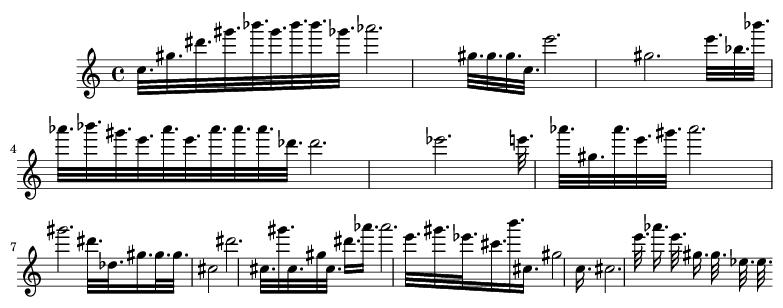

In [65]:
Image(myLilyPNG(generated_streams[0],lily_path))

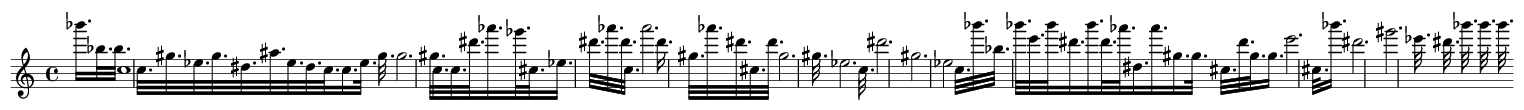

In [66]:
Image(myLilyPNG(generated_streams[1],lily_path))

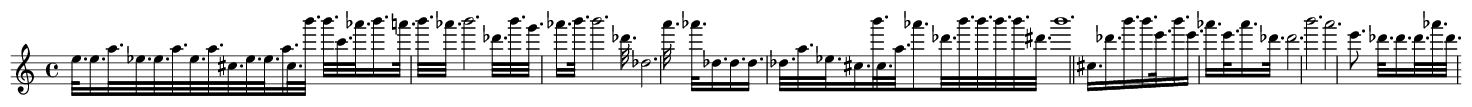

In [67]:
Image(myLilyPNG(generated_streams[2],lily_path))

In [68]:
# Ordner wieder loeschen
myLilyRemove(lily_path)